In [2]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split

In [3]:
cep_list = np.load("../dataset/light_curve_instance/cepheid/lc_cepheid.npy",
                                allow_pickle=True)
len(cep_list)

4648

In [29]:
demo_EB = np.load("../dataset/light_curve_instance/eclipsing_binary/demo_EB.npy",
                                allow_pickle=True)

In [4]:
CWA_list = [lc for lc in cep_list if lc.meta["variable_type"] == "CWA"]
CWB_list = [lc for lc in cep_list if lc.meta["variable_type"] == "CWB"]
DCEP_list = [lc for lc in cep_list if lc.meta["variable_type"] == "DCEP"]
DCEPS_list = [lc for lc in cep_list if lc.meta["variable_type"] == "DCEPS"]
RVA_list = [lc for lc in cep_list if lc.meta["variable_type"] == "RVA"]

In [5]:
CWA_period = [lc.meta["period"] for lc in CWA_list]
CWB_period = [lc.meta["period"] for lc in CWB_list]
DCEP_period = [lc.meta["period"] for lc in DCEP_list]
DCEPS_period = [lc.meta["period"] for lc in DCEPS_list]
RVA_period = [lc.meta["period"] for lc in RVA_list]

In [6]:
CWA_period_idx = np.intersect1d(np.argwhere(
    np.percentile(CWA_period, 20) < CWA_period), np.argwhere(
    np.percentile(CWA_period, 80) > CWA_period))
CWA_period = np.array(CWA_period)[CWA_period_idx]
min(CWA_period), max(CWA_period)

(13.7781739, 37.8442993)

In [7]:
import matplotlib.pyplot as plt
CWB_period_idx = np.intersect1d(np.argwhere(
    np.percentile(CWB_period, 20) < CWB_period), np.argwhere(
    np.percentile(CWB_period, 80) > CWB_period))
CWB_period = np.array(CWB_period)[CWB_period_idx]
min(CWB_period), max(CWB_period)
# plt.hist(EB_period, bins=100)"
# plt.show()

(0.9993567, 3.2673942)

In [8]:
DCEP_period_idx = np.intersect1d(np.argwhere(
    np.percentile(DCEP_period, 20) < DCEP_period), np.argwhere(
    np.percentile(DCEP_period, 80) > DCEP_period))
DCEP_period = np.array(DCEP_period)[DCEP_period_idx]
min(DCEP_period), max(DCEP_period)

(2.7816973, 8.0748448)

In [10]:
from matplotlib import pyplot as plt

CWA, CWB, DCEP,DCEPS,RVA = None, None, None,None,None

for lc in cep_list:
    if CWA and CWB and DCEP and DCEPS and RVA:
        break
    if lc.meta["class_probability"] > 0.99:
        if lc.meta["variable_type"] == "CWA":
            CWA = lc
        elif lc.meta["variable_type"] == "CWB":
            CWB = lc
        elif lc.meta["variable_type"] == "DCEP":
            DCEP = lc
        elif lc.meta["variable_type"] == "DCEPS":
            DCEPS = lc
        elif lc.meta["variable_type"] == "RVA":
            RVA = lc
    else:
        continue

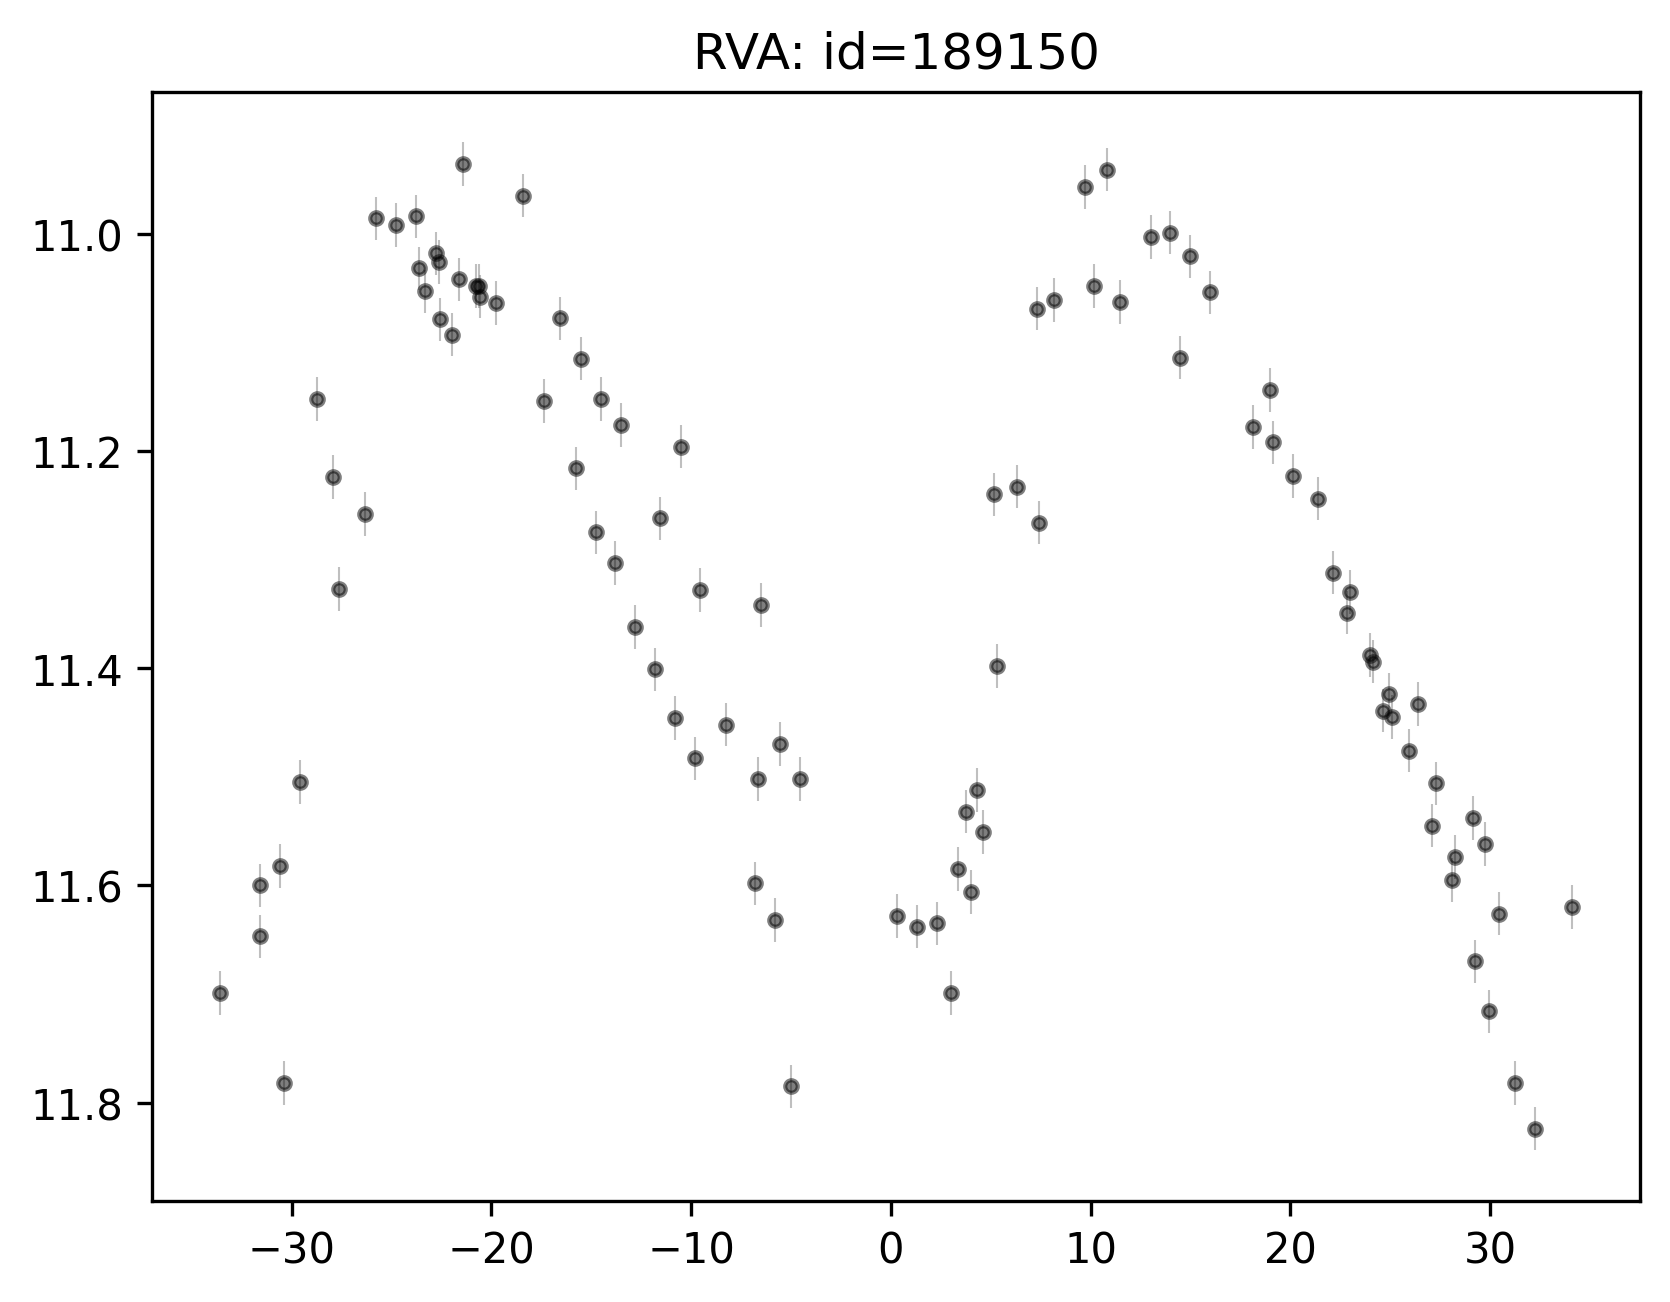

In [26]:
lc = RVA
time = lc.time.value
flux = lc.flux.value
flux_err = lc.flux_err.value
period = lc.meta["period"]

fig,ax = plt.subplots(dpi=300)
plt.errorbar(time, flux, yerr=flux_err, fmt='.', ecolor='gray', color='black', elinewidth=0.5, capsize=0,alpha=0.5)
ax.invert_yaxis()
plt.title(lc.meta["variable_type"]+": id="+ lc.meta["source_id"])
plt.show()

In [65]:
from scipy.optimize import leastsq


def residuals(pars, x, y, order):
    # 通过傅里叶级数所拟合出来的值与真实值之间的误差
    return y - fourier_series(pars, x, order)


def fourier_series(pars, x, order):
    # 傅里叶级数 s = a_0 + \sum_{i=1}^{N} a_i*sin(2*pi*i*x)+b_i*cos(2*pi*i*x)
    sum = pars[0]
    for i in range(order):
        sum += pars[i * 2 + 1] * np.sin(2 * np.pi * (i + 1) * x) \
               + pars[i * 2 + 2] * np.cos(2 * np.pi * (i + 1) * x)
    return sum


order = 5
time = np.array(time)
period = float(period)
p0 = np.ones(order * 2 + 1)
date_period = (time % period) / period
p1, success = leastsq(residuals, p0, args=(date_period, flux, order), maxfev=20000)
p1

array([ 1.44706614e+01, -4.60056454e-05,  1.66570815e-02,  6.17839056e-02,
        1.18914637e-01,  3.59120848e-03,  2.06004798e-03,  1.96615283e-02,
        1.32751051e-02,  5.05649622e-04,  5.36564017e-03])

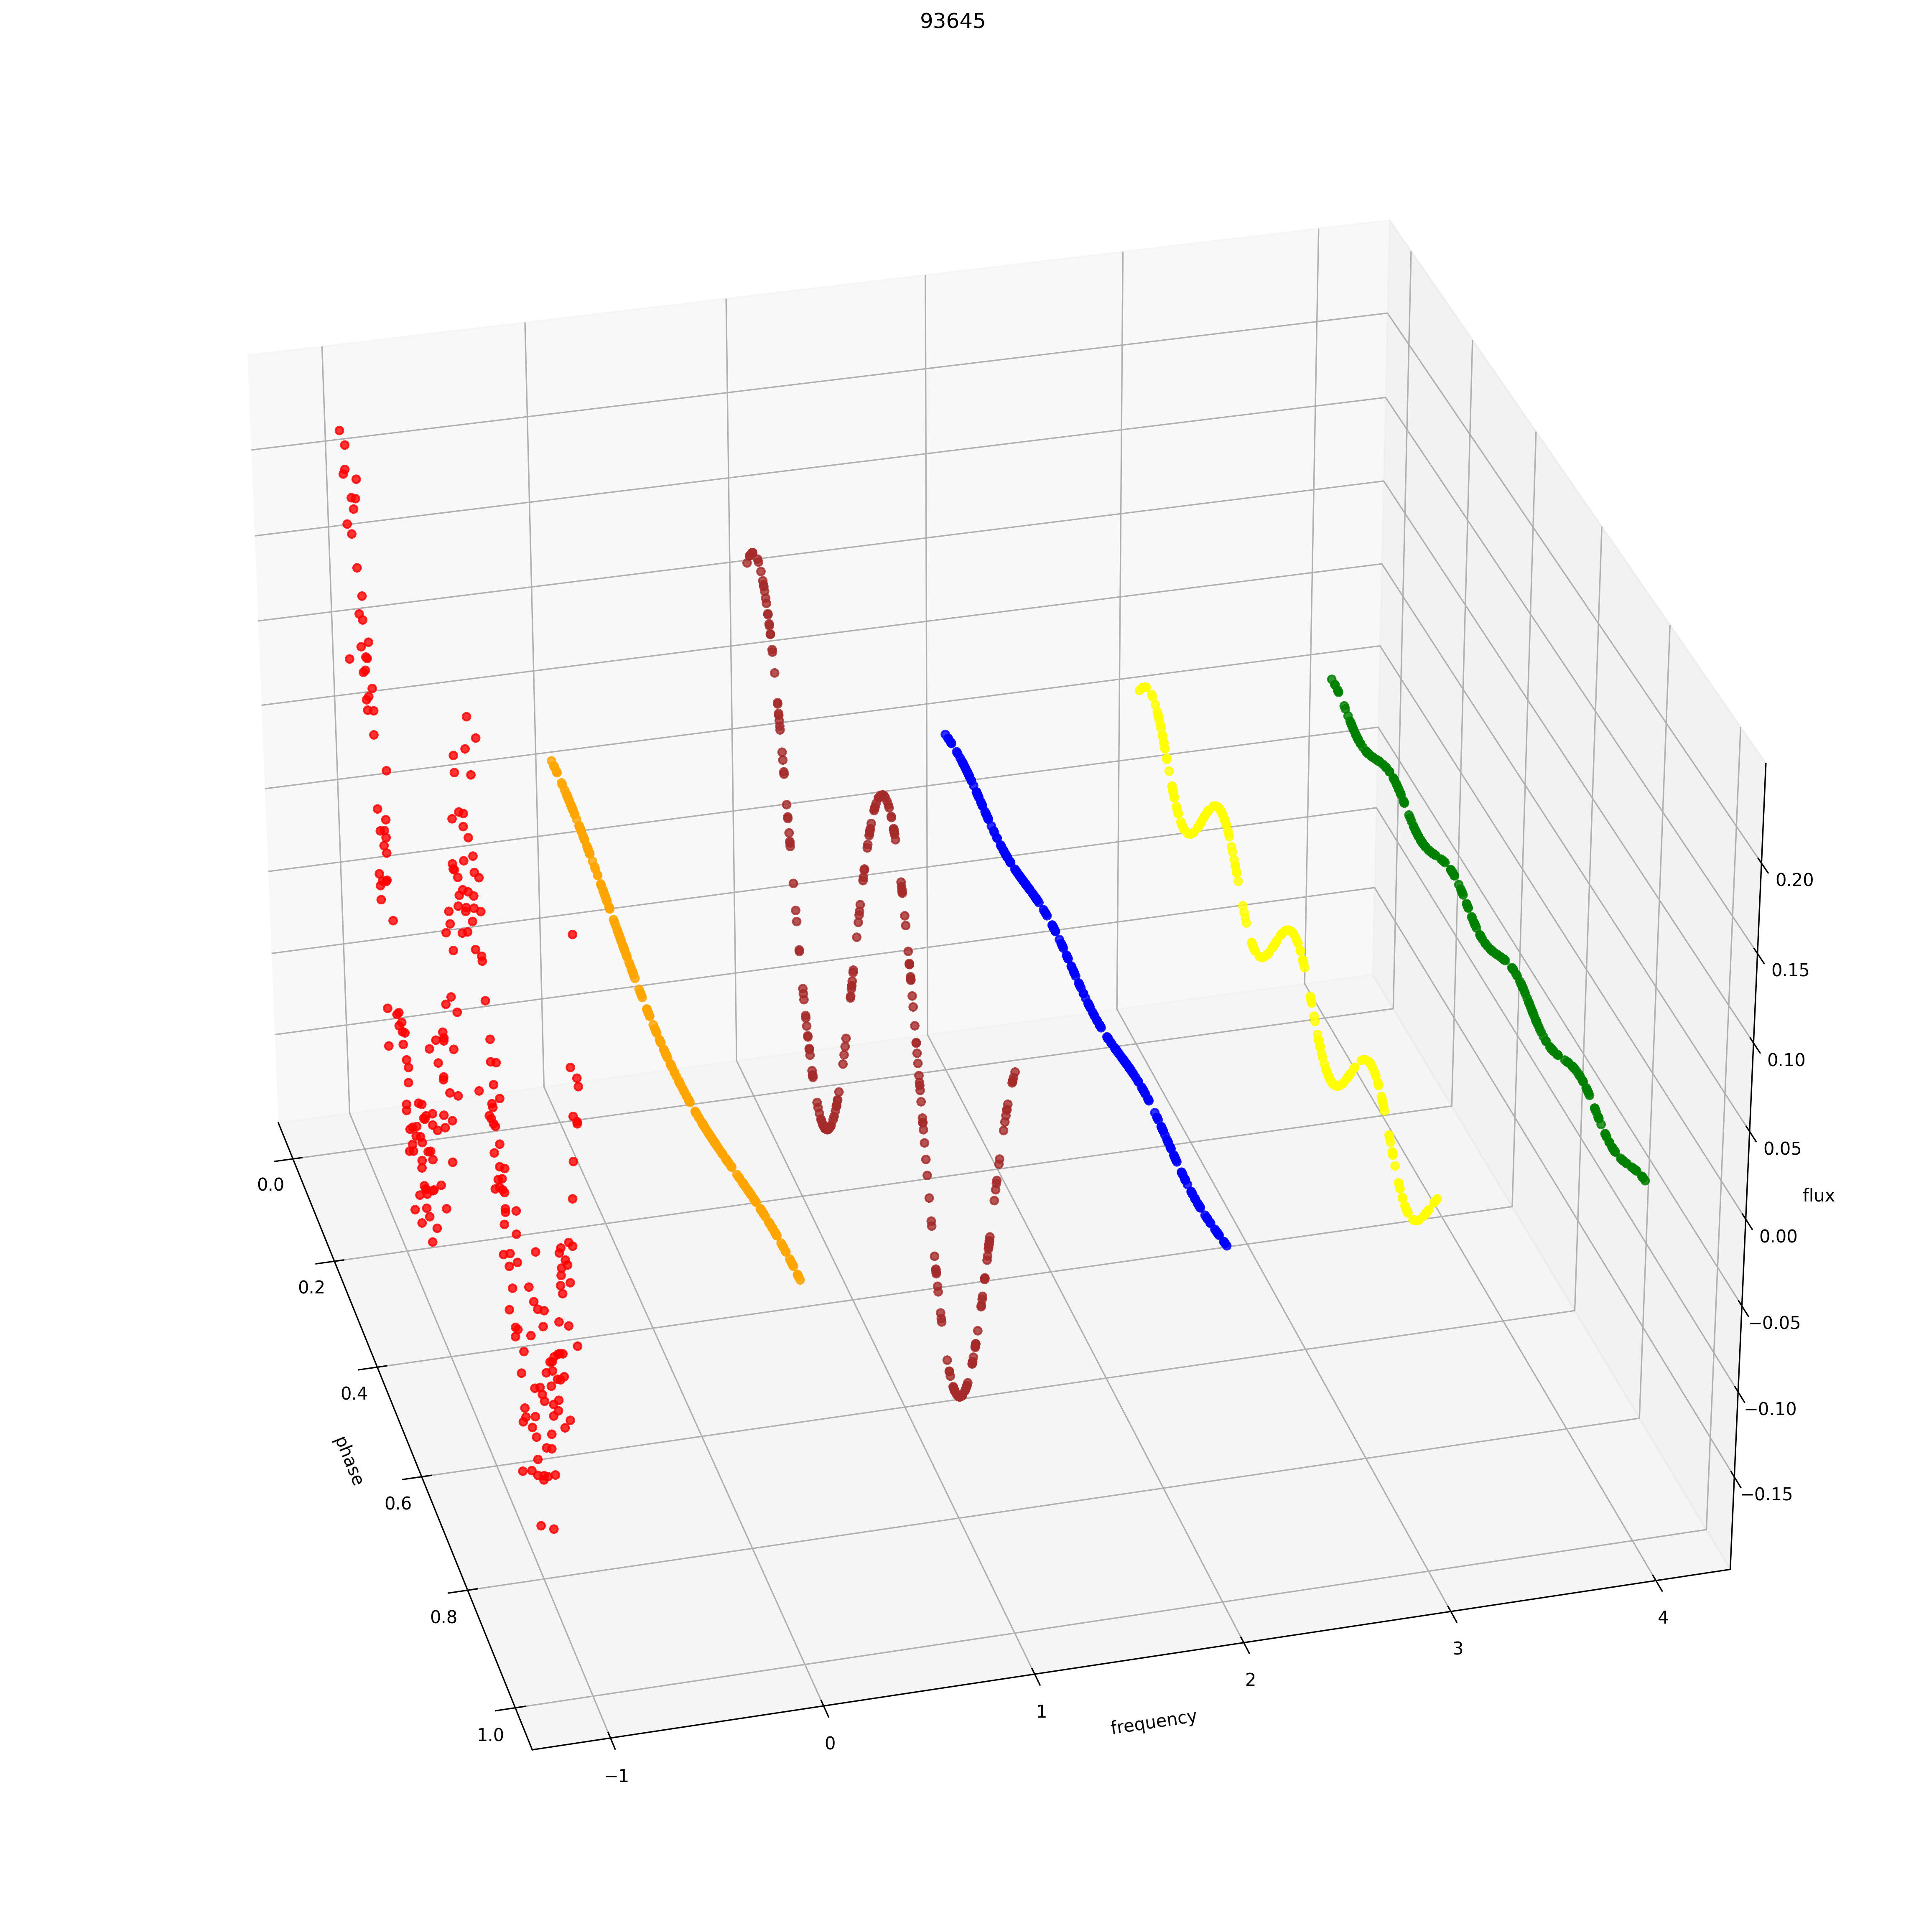

In [66]:
from mpl_toolkits.mplot3d import Axes3D

y_hat = p1[1] * np.sin(2 * np.pi * time) \
        + p1[2] * np.cos(2 * np.pi * time)

y_hats, t_hats, frequency_hats = [], [], []


def plot_fourier(t):
    for i in range(order):
        y_hat = p1[i * 2 + 1] * np.sin(2 * np.pi * (i + 1) * t) + p1[i * 2 + 2] * np.cos(2 * np.pi * (i + 1) * t)
        t_hat = t
        frequency_hat = [i for _ in range(len(t))]
        y_hats.extend(y_hat)
        t_hats.extend(t_hat)
        frequency_hats.extend(frequency_hat)


y_hats.extend(lc.flux.value - p1[0])
t_hats.extend(date_period)
frequency_hats.extend([-1 for _ in range(len(date_period))])

plot_fourier(date_period)
fig = plt.figure(figsize=(15, 15), dpi=300)
ax = Axes3D(fig, azim=-15)
fig.add_axes(ax)
map_color = {-1: 'red', 0: 'orange', 1: 'brown', 2: 'blue', 3: 'yellow', 4: 'green'}
color = [map_color[i] for i in frequency_hats]
ax.scatter(t_hats, frequency_hats, y_hats, c=color, marker='o', alpha=0.8)
ax.set_xlabel("phase")
ax.set_ylabel("frequency")
ax.set_zlabel("flux")
ax.set_title(lc.meta["source_id"])
plt.show()